In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [2]:
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [11]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='hrnet_w32_224_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [12]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [13]:
dls = db.dataloaders(df.values,bs=64,num_workers=0)

In [16]:
learn = Learner(dls,timm.create_model('hrnet_w32',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00010964782268274575)

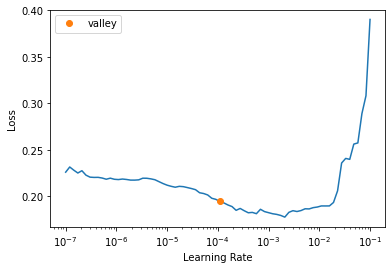

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.226423,1.496842,0.500000,0.000000,0.000000,0.000000,0.482784,02:34


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with f1_score value: 0.0.


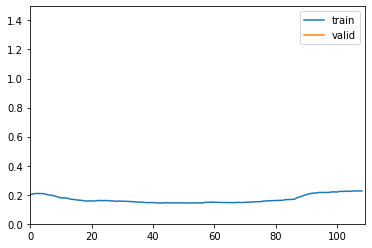

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.192506,0.183133,0.503846,0.502030,0.951282,0.657219,0.560966,02:34
1,0.186351,0.179662,0.517949,0.511864,0.774359,0.616327,0.542995,02:34
2,0.189589,0.203806,0.574359,0.646465,0.328205,0.435374,0.628534,02:32
3,0.183420,0.189986,0.601282,0.626198,0.502564,0.557610,0.672232,02:29
4,0.172467,0.165627,0.655128,0.677419,0.592308,0.632011,0.727380,02:28
5,0.159671,0.198352,0.626923,0.692607,0.456410,0.550232,0.716042,02:28
6,0.137346,0.137524,0.751282,0.718750,0.825641,0.768496,0.845105,02:31
7,0.133630,0.427963,0.762821,0.840532,0.648718,0.732272,0.861864,02:28
8,0.120543,0.144035,0.792308,0.823864,0.743590,0.781671,0.892114,02:29
9,0.114402,0.316720,0.762821,0.925311,0.571795,0.706815,0.887528,02:29


Better model found at epoch 0 with f1_score value: 0.6572187776793622.


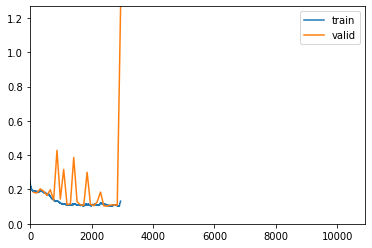

Better model found at epoch 6 with f1_score value: 0.7684964200477328.
Better model found at epoch 8 with f1_score value: 0.7816711590296497.
Better model found at epoch 10 with f1_score value: 0.8231292517006803.
Better model found at epoch 14 with f1_score value: 0.8247422680412372.
Better model found at epoch 21 with f1_score value: 0.8280871670702179.
No improvement since epoch 22: early stopping


In [17]:
learn.fine_tune(100,base_lr=3e-3)

In [18]:
dfTest = pd.read_csv('../testSample.csv')

In [19]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [20]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [21]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [22]:
learn.dls = dlsTest

In [23]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.938929651545036.


(#6) [0.08473334461450577,0.8733333349227905,0.850674373795761,0.9056410256410257,0.877297565822156,0.938929651545036]

# 384

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='hrnet_w32_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('hrnet_w32',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('hrnet_w32_224_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003311311302240938)

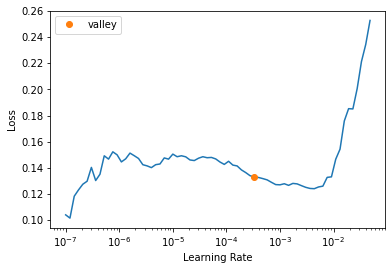

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.213498,0.206007,0.496154,0.333333,0.007692,0.015038,0.508481,04:03


Better model found at epoch 0 with f1_score value: 0.015037593984962405.


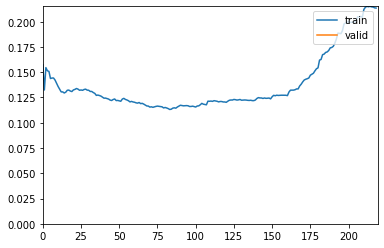

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.201937,0.179753,0.547436,0.540659,0.630769,0.582249,0.549543,04:11
1,0.187282,0.181705,0.530769,0.687500,0.112821,0.193833,0.588632,04:16
2,0.185024,0.209840,0.498718,0.499348,0.982051,0.662057,0.542380,04:17
3,0.185269,0.172843,0.515385,0.576923,0.115385,0.192308,0.574750,04:18
4,0.179390,0.173605,0.539744,0.530333,0.694872,0.601554,0.531976,04:18
5,0.185071,0.178430,0.505128,0.642857,0.023077,0.044554,0.557360,04:16
6,0.178666,0.173416,0.543590,0.623188,0.220513,0.325758,0.578343,04:18
7,0.178531,0.172346,0.521795,0.512859,0.869231,0.645100,0.604675,04:16
8,0.175948,0.183027,0.574359,0.561702,0.676923,0.613953,0.590805,04:17
9,0.173003,0.170451,0.555128,0.534400,0.856410,0.658128,0.579961,04:16


Better model found at epoch 0 with f1_score value: 0.5822485207100592.


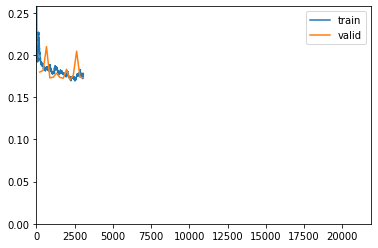

Better model found at epoch 2 with f1_score value: 0.662057044079516.
No improvement since epoch 9: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.5970177514792899.


(#6) [0.19401361048221588,0.5,0.5,1.0,0.6666666666666666,0.5970177514792899]

# 512

In [18]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='hrnet_w32_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [21]:
learn = Learner(dls,timm.create_model('hrnet_w32',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [22]:
learn.load('hrnet_w32_384_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=1.4454397387453355e-05)

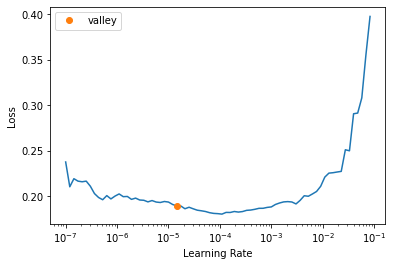

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.176438,2.524011,0.501282,0.500642,1.000000,0.667237,0.494928,09:11


Better model found at epoch 0 with f1_score value: 0.6672369546621043.


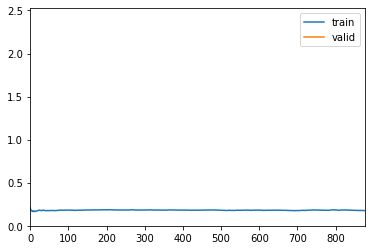

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.176135,0.178275,0.553846,0.592105,0.346154,0.436893,0.591068,09:09
1,0.179221,1.345446,0.512821,0.545455,0.153846,0.240000,0.505963,09:11
2,0.176451,0.464031,0.524359,0.584071,0.169231,0.262425,0.551213,09:11
3,0.173477,0.461325,0.597436,0.579498,0.710256,0.638249,0.604280,09:12
4,0.175335,0.168921,0.598718,0.623794,0.497436,0.553495,0.637433,09:13
5,0.175845,0.190058,0.608974,0.623188,0.551282,0.585034,0.622173,09:12
6,0.169980,0.228932,0.515385,0.551724,0.164103,0.252964,0.569826,09:06
7,0.172887,0.216811,0.512821,0.547170,0.148718,0.233871,0.555874,08:59
8,0.171846,0.224292,0.583333,0.587601,0.558974,0.572930,0.616345,09:00
9,0.174053,0.334316,0.502564,0.508929,0.146154,0.227092,0.535970,08:59


Better model found at epoch 0 with f1_score value: 0.4368932038834951.


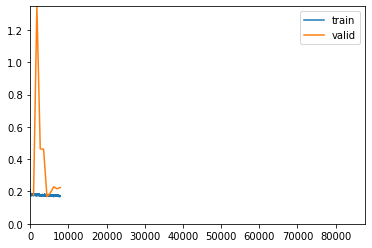

Better model found at epoch 3 with f1_score value: 0.6382488479262672.
No improvement since epoch 4: early stopping


In [24]:
learn.fine_tune(100,base_lr=3e-4)

In [25]:
dfTest = pd.read_csv('../testSample.csv')

In [26]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [28]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [29]:
learn.dls = dlsTest

In [30]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.655117422748192.


(#6) [0.28275951743125916,0.6179487109184265,0.608286252354049,0.6625641025641026,0.6342660775650466,0.655117422748192]